# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [3]:
import pandas as pd
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sys
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
#!{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api

# 1.1

In [4]:
import nltk
import numpy as np
import pandas as pd
import requests
def single_country_reviews(
    appID,
    country='us',
    page=1,
    df=pd.DataFrame()):

    url = 'https://itunes.apple.com/' + country \
          + '/rss/customerreviews/id=%s/page=%d/sortby=mostrecent/json' \
          % (appID, page)
    req = requests.get(url)
    try:
        data = req.json().get('feed')
        page_error = False
    except ValueError:
        return df.reset_index(drop=True)
    try:
        df_index = np.arange(len(data.get('entry')))
    except:
        return df.reset_index(drop=True)
    csvTitles = ['title', 'version', 'rating', 'review', 'vote_count']
    page_df = pd.DataFrame(index=df_index, columns=csvTitles)
    entry_index = -1  
    for entry in data.get('entry'):
        if entry.get('im:name'):
            continue
        entry_index += 1
        page_df.title.loc[entry_index] = entry.get('title').get('label')
        page_df.version.loc[entry_index] = entry.get('im:version').get('label')
        page_df.rating.loc[entry_index] = entry.get('im:rating').get('label')
        page_df.review.loc[entry_index] = entry.get('content').get('label')
        page_df.vote_count.loc[entry_index] = entry.get('im:voteCount').get(
            'label')

    page_df.dropna(axis=0, how='all', inplace=True)
    page_df.fillna({'title' : '', 'review' : '', 'version': ''})
    page_df.rating = pd.to_numeric(page_df.rating,
                                   downcast='unsigned',
                                   errors='coerce')
    page_df.vote_count = pd.to_numeric(page_df.vote_count,
                                       downcast='unsigned',
                                       errors='coerce')
    if not page_error:
        return single_country_reviews(
            appID,
            country=country,
            page=page + 1,
            df=df.append(page_df).reset_index(drop=True))
def get_reviews(
    appID,
    list_countries=list(['us', 'gb', 'ca', 'au', 'ie', 'nz'])):

    if type(list_countries) == str:
        list_countries = [list_countries]
    df = pd.DataFrame()
    for country in list_countries:
        df=df.append(
            single_country_reviews(appID, country=country)
            ).reset_index(drop=True)
    return df
# Candy Crush is ID 553834731
facebook = get_reviews(284882215)
candy = get_reviews(553834731)
twitter = get_reviews(333903271)
tinder = get_reviews(547702041)

In [6]:
app_dfs = [facebook,candy,twitter,tinder]

In [7]:
data = pd.concat(app_dfs)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
COMPRESSED_SIZE = 200
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['review'])
Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

In [ ]:
# R2 for tfidf 

In [28]:
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ data['rating'].values
print("OLS R^2: ", r2_score(data['rating'], pred))

OLS R^2:  0.4865400340361119


In [29]:
from sklearn.cluster import KMeans
k = 5
model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1)
model.fit(X)
clusters = model.predict(X)

In [30]:
from scipy.stats import mode
data['rating'] = data['rating'].astype(int)
y = np.array(data['rating'])
labels = np.zeros_like(clusters)
for i in range(5):
    mask = (clusters == i)
    labels[clusters == i] = mode(y[clusters == i])[0]

data['kmeans_tfidf'] = labels

In [31]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(data['kmeans_tfidf'],y))
print(accuracy_score(data['kmeans_tfidf'],y))

              precision    recall  f1-score   support

           1       1.00      0.59      0.74     11190
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.24      0.85      0.38       810

    accuracy                           0.61     12000
   macro avg       0.25      0.29      0.22     12000
weighted avg       0.95      0.61      0.72     12000

0.6061666666666666


# 1.2

In [10]:
data2 = data.copy()
data2.columns = [x.lower() for x in data2.columns]
data2

,title,version,rating,review,vote_count,kmeans_tfidf
0,Facebook dating not working,308.0,1,Gladly change to 5 stars once developer can fi...,0,1
1,copy text,308.0,1,升级了 文字 还是不能复制 。,0,1
2,Hate New Outlook!!,308.0,1,Hate the new Facebook profile outlook 😡🤬😡,0,1
3,#delete Facebook,308.0,1,Why delete Facebook it’s using behaviorism tec...,0,1
4,Gifs don’t work,308.0,1,Anything but what you guys are doing would be ...,0,1
...,...,...,...,...,...,...
2995,Playing up,6.8.1,1,The app glitches and all my matches/messages a...,0,1
2996,Server Error,6.8.0,1,"Can never use it, it always says 'Server Error...",0,1
2997,Love it,6.8.1,5,Love this app!!! I was travelling in Europe an...,0,1
2998,LOST ALL MATCHES,6.8.0,1,I have yet again lost ALL my matches! Could yo...,0,1


In [11]:
words = data2.review.str.split()
words = pd.DataFrame(words.tolist())

In [12]:
import re

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = data2.review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())


In [13]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [14]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))
emb = emb.fillna(0)

In [15]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import Normalizer,StandardScaler

X1 = Normalizer().fit_transform(emb) 
sgdr = SGDRegressor()
sgdr.fit(X1, data2['rating'])
data2['gensim'] = sgdr.predict(X1)
print("R2 Gensim:", sgdr.score(X1, data2['rating']))

R2 Gensim: 0.34878365389986543


In [16]:
from sklearn.metrics import r2_score
pred = sgdr.predict(X1)
r2_score(data2['rating'], pred)

0.34878365389986543

In [17]:
k = 5
model1 = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1)
model1.fit(X1)
clusters1 = model1.predict(X1)

In [18]:
from scipy.stats import mode
data2['rating'] = data2['rating'].astype(int)
y1 = np.array(data2['rating'])
labels1 = np.zeros_like(clusters1)
for i in range(5):
    mask = (clusters1 == i)
    labels1[clusters1 == i] = mode(y1[clusters1 == i])[0]

data2['kmeans_gen'] = labels1

In [19]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(data2['kmeans_gen'],y1))
print(accuracy_score(data2['kmeans_gen'],y1))

              precision    recall  f1-score   support

           1       0.96      0.61      0.75     10425
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.40      0.71      0.51      1575

    accuracy                           0.62     12000
   macro avg       0.27      0.26      0.25     12000
weighted avg       0.89      0.63      0.72     12000

0.625


# 1.3

In [32]:
data3 = data.copy()
mean_rating = data3['rating'].mean()

new_df = data3[data3['rating'] > mean_rating]
new_df = new_df.reset_index()

new_df.columns = [x.lower() for x in new_df.columns]

words1 = new_df.review.str.split()
words1 = pd.DataFrame(words1.tolist())

In [34]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words1 = new_df.review.str.replace(pattern, replacer).str.lower().str.split()
words1 = pd.DataFrame(words1.tolist())


In [38]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb1 = pd.DataFrame(words1.apply(map_vectors, axis=1))
emb1.columns = ['C']
emb1 = pd.DataFrame(np.array(emb1.C.apply(pd.Series)))
emb1 = emb1.fillna(0)


In [40]:
X2 = Normalizer().fit_transform(emb1) 

array([[ 0.06199514,  0.0584798 , -0.01716958, ..., -0.04675848,
        -0.01587353,  0.00914542],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06573265, -0.01045964,  0.05078341, ..., -0.02162408,
        -0.01285243,  0.02829294],
       ...,
       [ 0.0820234 ,  0.01253322,  0.01708117, ..., -0.01007311,
         0.02148552,  0.07429486],
       [ 0.0037242 , -0.03539795,  0.05427335, ...,  0.03500308,
         0.10450407,  0.19709812],
       [ 0.06188499,  0.07729252, -0.03340843, ..., -0.1050199 ,
         0.00882097, -0.02930873]])

In [41]:
x = X2
y = new_df['rating']

new_model = sm.OLS(y, x).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 rating   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                              1153.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):                        0.00
Time:                        12:45:15   Log-Likelihood:                         -6889.7
No. Observations:                4323   AIC:                                  1.388e+04
Df Residuals:                    4273   BIC:                                  1.420e+04
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -7.8377      1.067     -7.348      0.000      -9.929      -5.746
x2            -7.5550      1.073     -7.042      0.000      -9.658      -5.452
x3             7.8419      1.218      6.441      0.000       5.455      10.229
x4            -1.3887      1.124     -1.235      0.217      -3.593       0.816
x5            -7.1652      1.289     -5.559      0.000      -9.692      -4.638
x6             1.0472      0.895      1.170      0.242      -0.707       2.802
x7            12.4857      1.715      7.282      0.000       9.124      15.847
x8            -0.8260      1.660     -0.497      0.619      -4.081       2.429
x9             3.1565      0.738      4.279      0.000       1.710       4.603
x10           -2.9784      1.450     -2.054      0.040      -5.821      -0.136
x11           -9.4751      2.289     -4.139      0.000     -13.963      -4.987
x12           12.8973      1.741      7.408      0.000       9.484      16.310
x13           12.4134      1.562      7.947      0.000       9.351      15.476
x14           10.7232      1.205      8.900      0.000       8.361      13.085
x15           17.8178      1.707     10.438      0.000      14.471      21.164
x16           -2.2404      1.631     -1.374      0.170      -5.438       0.957
x17            4.4730      1.419      3.153      0.002       1.692       7.254
x18           -0.9853      1.869     -0.527      0.598      -4.650       2.680
x19           -3.2850      1.438     -2.285      0.022      -6.103      -0.467
x20            9.9410      1.630      6.099      0.000       6.745      13.137
x21           -7.0118      1.271     -5.517      0.000      -9.504      -4.520
x22            9.5403      1.908      5.001      0.000       5.800      13.280
x23          -10.9971      1.405     -7.826      0.000     -13.752      -8.242
x24           -1.3856      2.087     -0.664      0.507      -5.477       2.706
x25           -5.9991      2.064     -2.906      0.004     -10.046      -1.952
x26            1.3617      2.129      0.640      0.522      -2.812       5.536
x27           -2.2247      0.724     -3.071      0.002      -3.645      -0.805
x28            6.6505      2.320      2.867      0.004       2.103      11.199
x29           -2.7275      1.474     -1.850      0.064      -5.617       0.162
x30           -1.1307      1.437     -0.787      0.431      -3.948       1.687
x31           10.1376      0.918     11.041      0.000       8.337      11.938
x32            7.7342      1.164      6.644      0.000       5.452      10.017
x33            3.0799      1.864      1.652      0.099      -0.575       6.735
x34           -5.2233      1.222     -4.273      0.000      -7.620      -2.827
x35           11.6880      1.662      7.034      0.000       

# 1.4

In [ ]:
"""
The Classifaction model yielded a better predict rate of the 5 star reviews
in comparison to the models above.

Looking at the classifaction report as well, it seems like the metrics are a lot
more distributed, than the models above.

the models above had split them into either cluster 1 or 5.

This supervised learning method is better at predicting which review score
the data belongs to, based on its features


"""

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
y3 = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
y_preds = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


In [26]:
print(classification_report(y_test, y_preds))
print(accuracy_score(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.68      0.96      0.80      1969
           2       0.23      0.02      0.03       326
           3       0.30      0.03      0.06       239
           4       0.25      0.02      0.04       223
           5       0.75      0.67      0.70       843

    accuracy                           0.69      3600
   macro avg       0.44      0.34      0.33      3600
weighted avg       0.60      0.69      0.61      3600

0.6863888888888889


## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [52]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

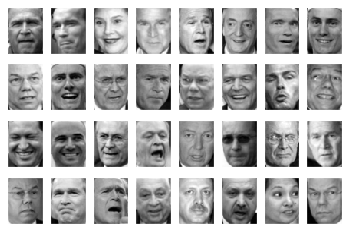

In [55]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

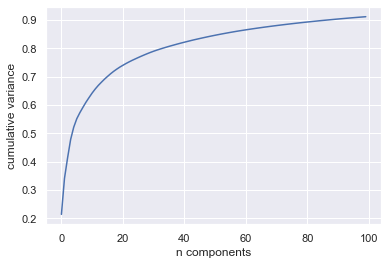

In [63]:
from sklearn.decomposition import PCA as RandomizedPCA

face_model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(face_model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

In [64]:
from sklearn.manifold import Isomap
faces_model = Isomap(n_components=2)
proj = faces_model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [65]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = faces_model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

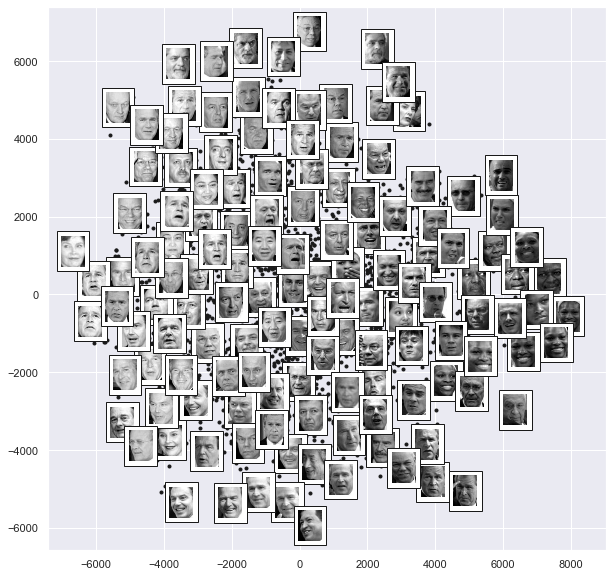

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])